<a href="https://colab.research.google.com/github/Sim98B/MushroomVision/blob/main/MushD4/MushDetector4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Detector

## Setup

In [22]:
# Importing main libraries
try:
  import torch
  import torchvision
  import torchinfo
except:
  print("[INFO] Torch and Torchvision not installed, downloading")
  !pip install -q torch torchvision torchinfo
import torch
print(f"torch: {torch.__version__}")
import torchvision
print(f"torchvision: {torchvision.__version__}")
import torchinfo
print(f"torchinfo: {torchinfo.__version__}")

# Utilities
import os
from pathlib import Path
import requests
import shutil
from timeit import default_timer as timer
import itertools
import warnings
warnings.filterwarnings("ignore")

# Manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Neural networks
from torch import nn
from torchvision import transforms
import torchvision.models
from torchinfo import summary

# Metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Cloning GitHub repository
!git clone https://github.com/Sim98B/MushroomVision
!mv MushroomVision/Modules/Libraries .

# Custom functions
from Libraries import data, extractors, model_ops, utils

shutil.rmtree("MushroomVision")

torch: 2.1.0+cu118
torchvision: 0.16.0+cu118
torchinfo: 1.8.0
Cloning into 'MushroomVision'...
remote: Enumerating objects: 64124, done.
remote: Counting objects: 100% (64124/64124), done.
remote: Compressing objects: 100% (63009/63009), done.
remote: Total 64124 (delta 1037), reused 64092 (delta 1012), pack-reused 0
Receiving objects: 100% (64124/64124), 700.64 MiB | 16.59 MiB/s, done.
Resolving deltas: 100% (1037/1037), done.
Updating files: 100% (1739/1739), done.
mv: cannot move 'MushroomVision/Modules/Libraries' to './Libraries': Directory not empty


In [23]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data: [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html)
The best way to identify those photos that contain photos is to use photos of 100 different subjects.

In [24]:
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform = tensor_transform)
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform = tensor_transform)

print(f"{len(train_data)} images for train divided into {len(train_data.classes)} classes")
print(f"{len(test_data)} images for train divided into {len(test_data.classes)} classes")




  0%|          | 0/169001437 [00:00<?, ?it/s]


  0%|          | 65536/169001437 [00:00<07:38, 368377.69it/s]


  0%|          | 196608/169001437 [00:00<03:34, 786003.82it/s]


  0%|          | 425984/169001437 [00:00<02:03, 1366288.45it/s]


  1%|          | 851968/169001437 [00:00<01:10, 2388913.69it/s]


  1%|          | 1703936/169001437 [00:00<00:37, 4434795.78it/s]


  2%|▏         | 3080192/169001437 [00:00<00:22, 7433066.01it/s]


  3%|▎         | 5537792/169001437 [00:00<00:12, 12838827.27it/s]


  5%|▌         | 8880128/169001437 [00:00<00:08, 19219622.56it/s]


  7%|▋         | 12124160/169001437 [00:00<00:06, 23057651.60it/s]


  9%|▉         | 15237120/169001437 [00:01<00:06, 25292578.70it/s]


 11%|█▏        | 19202048/169001437 [00:01<00:05, 25988777.19it/s]


 13%|█▎        | 22740992/169001437 [00:01<00:05, 28542096.57it/s]


 16%|█▌        | 26411008/169001437 [00:01<00:04, 30821913.70it/s]


 18%|█▊        | 30113792/169001437 [00:01<00:04, 32589028.87it/s]


 20%

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
50000 images for train divided into 100 classes
10000 images for train divided into 100 classes


In [ ]:
# We have a mushroom class in this dataset, at index 51
for i in range(len(train_data.classes)):
  if train_data.classes[i] == "mushroom":
    print(f"{i+1}. {train_data.classes[i].upper()}")

class_names = train_data.classes

52. MUSHROOM


## Baseline
As in the [PyTorch example](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) we are going to use a simple convolutional baseline model.

In [ ]:
# Creating a simple convolutional model
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 100)

  def forward(self, x):
    x = self.pool(torch.nn.functional.relu(self.conv1(x)))
    x = self.pool(torch.nn.functional.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = Classifier()
model

Classifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)

In [ ]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = 32,
                                           shuffle = True,
                                           num_workers = os.cpu_count(),
                                           pin_memory = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = 32,
                                          shuffle = False,
                                          num_workers = os.cpu_count(),
                                          pin_memory = True)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Trainig the model for 30 epochs
results = model_ops.train(model = model,
                          train_dataloader = train_loader,
                          test_dataloader = test_loader,
                          loss_function = criterion,
                          optimizer = optimizer,
                          metric = "accuracy",
                          epochs = 30,
                          device = device,
                          verbose = 1)

Training:   0%|          | 0/30 [00:00<?, ?it/s]

Despite the many epochs of learning a simple baseline cannot fully capture the differences between classes. Therefore, we will be 4 pre-trained models, **AlexNet**, **VGG**, **DenseNet** and **ResNet**, using a couple of slice of the whole dataset: a random **10%** and **20%** of the train set.

## Setting up experiments
Our motto is **start simple** and **add complexity then**.

### Getting the 10% and 20% datasets from **CIFAR100**

In [ ]:
# Using a StratifiedShuffleSplit to get indices for both slices
from sklearn.model_selection import StratifiedShuffleSplit

# A simple tensor transform
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Data
dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=tensor_transform)

# Setting up slicers
stratified_split_10_percent = StratifiedShuffleSplit(n_splits = 1, train_size = 0.1, random_state = 42)
stratified_split_20_percent = StratifiedShuffleSplit(n_splits = 1, train_size = 0.2, random_state = 42)

# Indices
indices_10_percent = next(stratified_split_10_percent.split(dataset.data, dataset.targets))
indices_20_percent = next(stratified_split_20_percent.split(dataset.data, dataset.targets))

# New datasets
dataset_10percent = torch.utils.data.Subset(dataset, indices_10_percent[0])
dataset_20percent = torch.utils.data.Subset(dataset, indices_20_percent[0])

len(dataset_10percent), len(dataset_20percent)

Files already downloaded and verified


(5000, 10000)

### Getting ready with 4 features extractors

In [ ]:
ALEXNET, alexnet_transformer = extractors.create_model(model_name = "alexnet", output_shape = len(class_names))
VGG, vgg_transformer = extractors.create_model(model_name = "vgg16", output_shape = len(class_names))
DENSENET, densenet_transformer = extractors.create_model(model_name = "densenet121", output_shape = len(class_names))
RESNET, resnet_transformer = extractors.create_model(model_name = "resnet50", output_shape = len(class_names))

for model in [ALEXNET, VGG, DENSENET, RESNET]:
  if model.__class__.__name__ != "ResNet":
    print(f"{model.__class__.__name__} params:\nTOTAL: {summary(model, input_size = (32, 3, 256, 256)).total_params:,}\nTRAINABLE: {summary(model, input_size = (32, 3, 256, 256)).trainable_params:,}")
  else:
    print(f"{model.__class__.__name__} params:\nTOTAL: {summary(model, input_size = (32, 3, 232, 232)).total_params:,}\nTRAINABLE: {summary(model, input_size = (32, 3, 232, 232)).trainable_params:,}")

AlexNet params:
TOTAL: 57,413,540
TRAINABLE: 409,700
VGG params:
TOTAL: 134,670,244
TRAINABLE: 409,700
DenseNet params:
TOTAL: 7,056,356
TRAINABLE: 102,500
ResNet params:
TOTAL: 23,712,932
TRAINABLE: 204,900


In [ ]:
# Downloading test data; they will be the same for both 10% and 20% experiments
test_data = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform = tensor_transform)

Files already downloaded and verified


In [ ]:
utils.set_seed()
experiment_number = 0

models = ["alexnet", "vgg16", "densenet121", "resnet50"]
data_percentages = ["10%", "20%"]
epochs = [5, 10]

for extractor, data, epoch in itertools.product(models, data_percentages, epochs):
  experiment_number += 1
  print(f"Experiment n°{experiment_number}, model: {extractor}, {data} data, {epoch} epochs")

  train_data = dataset_10percent.dataset if data == "10%" else dataset_20percent.dataset

  model, transformer = extractors.create_model(model_name = extractor, output_shape=len(class_names))
  train_data.transform = transformer
  test_data.transform = transformer

  experiment_train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                        batch_size=32,
                                                        shuffle=True,
                                                        num_workers=os.cpu_count(),
                                                        pin_memory=True)

  experiment_val_loader = torch.utils.data.DataLoader(dataset=test_data,
                                                      batch_size=32,
                                                      shuffle=False,
                                                      num_workers=os.cpu_count(),
                                                      pin_memory=True)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

  model_ops.train(model = model,
                  train_dataloader = experiment_train_loader,
                  test_dataloader = experiment_val_loader,
                  loss_function = criterion,
                  optimizer = optimizer,
                  metric = "accuracy",
                  epochs = epoch,
                  device = device,
                  writer = utils.create_writer(experiment_name = f"{epoch}_epochs",
                                               model_name = model.__class__.__name__,
                                               extra = f"{data}_data"),
                  verbose = 1)

Experiment n°1, model: alexnet, 10% data, 5 epochs
[INFO] Created SummaryWriter, saving to: runs/2023-11-27/5_epochs/AlexNet/10%_data...


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Experiment n°2, model: alexnet, 10% data, 10 epochs
[INFO] Created SummaryWriter, saving to: runs/2023-11-27/10_epochs/AlexNet/10%_data...


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Experiment n°3, model: alexnet, 20% data, 5 epochs
[INFO] Created SummaryWriter, saving to: runs/2023-11-27/5_epochs/AlexNet/20%_data...


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Experiment n°4, model: alexnet, 20% data, 10 epochs
[INFO] Created SummaryWriter, saving to: runs/2023-11-27/10_epochs/AlexNet/20%_data...


Training:   0%|          | 0/10 [00:00<?, ?it/s]

Experiment n°5, model: vgg16, 10% data, 5 epochs
[INFO] Created SummaryWriter, saving to: runs/2023-11-27/5_epochs/VGG/10%_data...


Training:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

## Difficult task, complex models
According to the [PyTorch pre-trained models page](https://pytorch.org/vision/stable/models.html) model we used have the metrics **Acc@1** and **Acc@5** respectively like this:

| Model name | Acc@1 | Acc@5 | Params |
|:----------:|:-----:|:-----:|:------:|
| AlexNet    | 56.522 | 79.066| 61.1M |
| VGG16      | 71.592 | 90.382 | 138.4 M |
| DenseNet121 | 74.434 | 91.972 | 8M |
| ResNet50      | 76.130 | 92.862 | 25.6M |

In [ ]:
model_dict1 = {"Model":["AlexNet", "VGG16", "DenseNet121", "ResNet50"],
               "Acc@1":[56.522, 71.592, 74.434, 76.130],
               "Acc@5":[79.066, 90.382, 91.972, 92.862],
               "Params (M)":[61.1, 138.4, 8, 25.6]}
df1 = pd.DataFrame(model_dict1)
df1.set_index("Model", inplace = True)
df1.head()

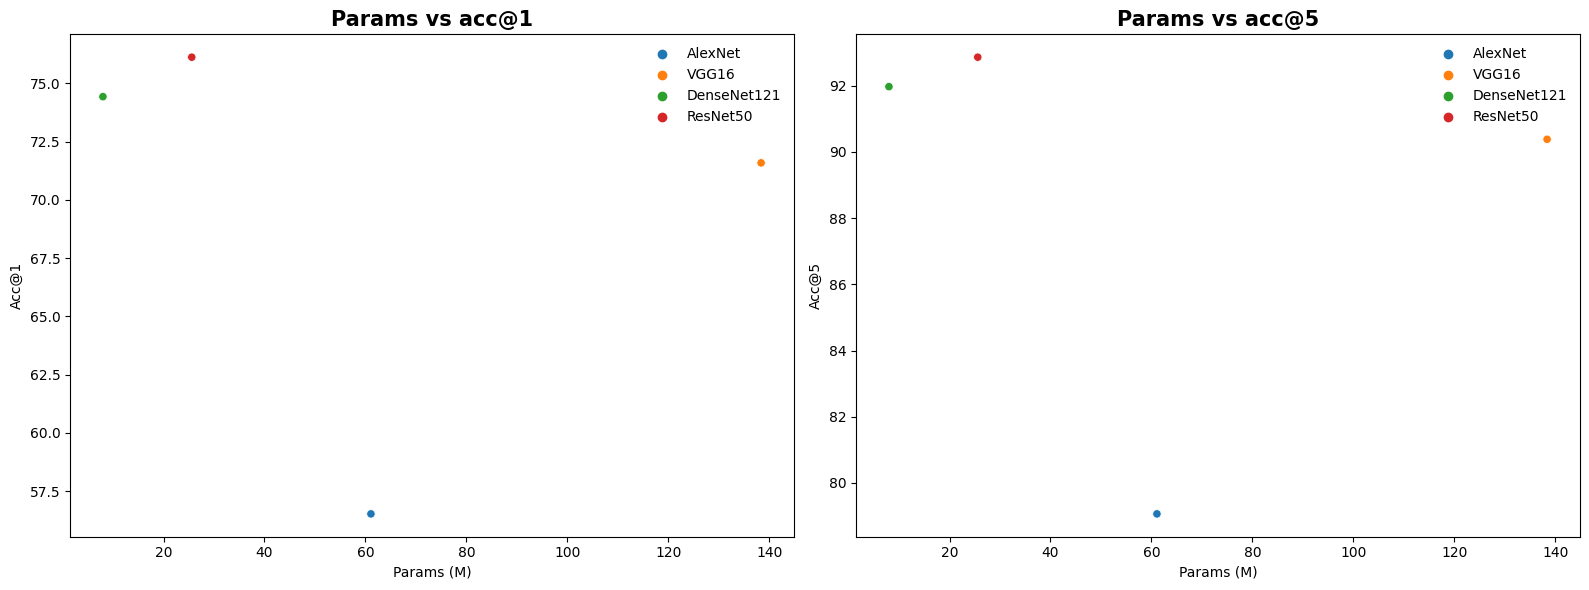

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))
ax1 = plt.subplot(121)
sns.scatterplot(data = df1, x = "Params (M)", y = "Acc@1", hue = "Model")
ax1.set_xlabel("Params (M)")
ax1.set_ylabel("Acc@1")
ax1.set_title("Params vs acc@1", weight = "bold", fontsize = 15)
ax1.legend(frameon = False)
ax2 = plt.subplot(122)
sns.scatterplot(data = df1, x = "Params (M)", y = "Acc@5", hue = "Model")
ax2.set_xlabel("Params (M)")
ax2.set_ylabel("Acc@5")
ax2.set_title("Params vs acc@5", weight = "bold", fontsize = 15)
ax2.legend(frameon = False)
plt.tight_layout();

This task is, however, too complex and therefore we need much more precise models. For each family of models we will select those with a value of **acc@1** greater than 80.

| Model name | Acc@1 | Acc@5 | Params |
|:----------:|:-----:|:-----:|:------:|
| ConvNeXt_Large | 84.414 | 96.976 | 197.8M |
| EfficientNet_V2_L | 85.808 | 97.788 | 118.5M |
| MaxVit_T | 83.700 | 96.722 | 30.9M |
| RegNet_Y_128GF | 88.228 | 98.682 | 644.8M |
| ResNetXt101_64X4d | 83.246 | 96.454 | 83.5M |
| ResNet152 | 82.284 | 96.002 | 60.2M |
| Swin_V2_B | 84.112 | 96.864 | 87.9M |
| ViT_H_14 | 88.552 | 98.694 | 633.5M |
| Wide_ResNet101_2 | 82.510 | 96.020 | 126.9M |

In [ ]:
model_dict2 = {"Model":["ConvNeXt_Large", "EfficientNet_V2_L", "MaxVit_T", "RegNet_Y_128GF", "ResNetXt101_64X4d", "ResNet152", "Swin_V2_B",
                        "ViT_H_14", "Wide_ResNet101_2"],
               "Acc@1":[84.414, 85.808, 83.700, 88.228, 83.246, 82.284, 84.112, 88.552, 82.510],
               "Acc@5":[96.976, 97.788, 96.722, 98.682, 96.454, 96.002, 96.864, 98.694, 96.020],
               "Params (M)":[197.8, 118.5, 30.9, 644.8, 83.5, 60.2, 87.9, 633.5, 126.9]}
df2 = pd.DataFrame(model_dict2)
df2.set_index("Model", inplace = True)
df2

,Acc@1,Acc@5,Params (M)
Model,,,
ConvNeXt_Large,84.414,96.976,197.8
EfficientNet_V2_L,85.808,97.788,118.5
MaxVit_T,83.700,96.722,30.9
RegNet_Y_128GF,88.228,98.682,644.8
ResNetXt101_64X4d,83.246,96.454,83.5
ResNet152,82.284,96.002,60.2
Swin_V2_B,84.112,96.864,87.9
ViT_H_14,88.552,98.694,633.5
Wide_ResNet101_2,82.510,96.020,126.9


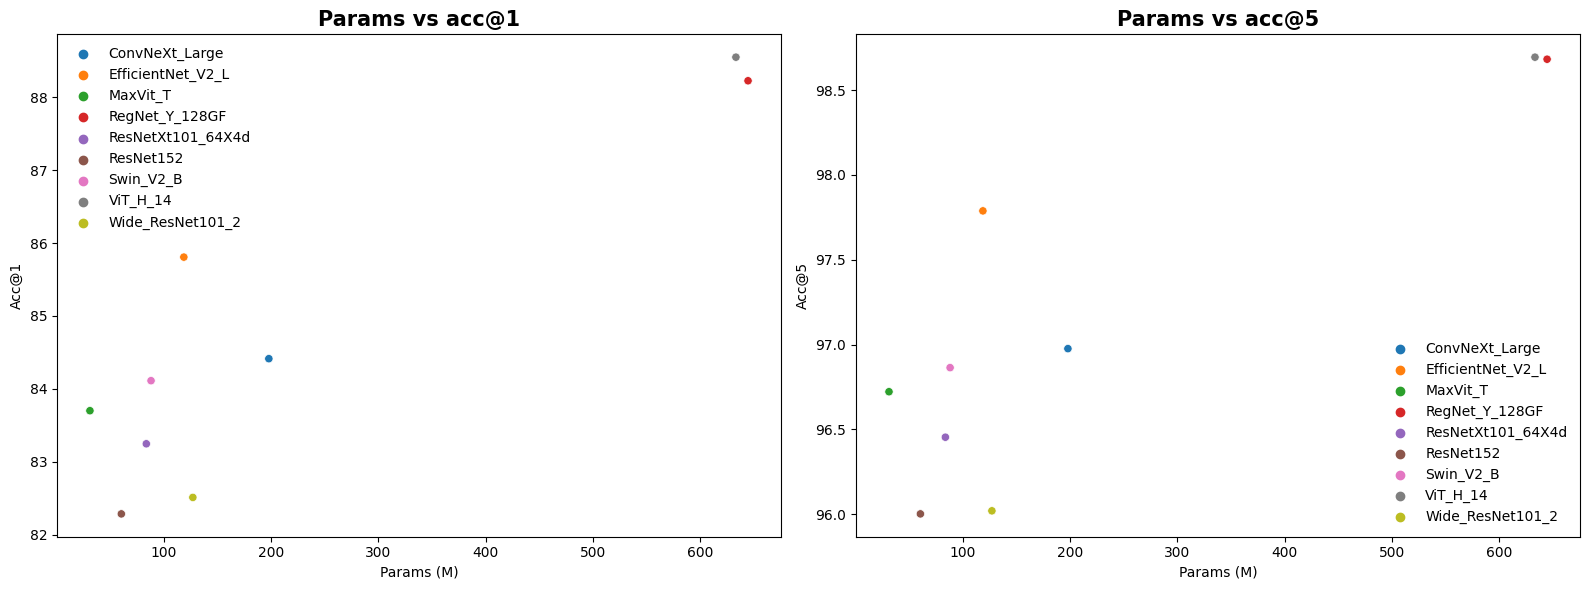

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))
ax1 = plt.subplot(121)
sns.scatterplot(data = df2, x = "Params (M)", y = "Acc@1", hue = "Model")
ax1.set_xlabel("Params (M)")
ax1.set_ylabel("Acc@1")
ax1.set_title("Params vs acc@1", weight = "bold", fontsize = 15)
ax1.legend(frameon = False)
ax2 = plt.subplot(122)
sns.scatterplot(data = df2, x = "Params (M)", y = "Acc@5", hue = "Model")
ax2.set_xlabel("Params (M)")
ax2.set_ylabel("Acc@5")
ax2.set_title("Params vs acc@5", weight = "bold", fontsize = 15)
ax2.legend(frameon = False)
plt.tight_layout();

**EfficientNet_V2_L** seems to be a fair trade-off between model size, in terms of parameters, and accuracy, indicated by **acc@1** and **acc@5**.

### A fair trade-off

In [ ]:
extractors.create_model()

In [ ]:
model, transformer = extractors.create_model(model_name = "efficientnet_b1", output_shape=len(class_names))
train_data = dataset_10percent.dataset
train_data.transform = transformer
test_data.transform = transformer

experiment_train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                                        batch_size=32,
                                                        shuffle=True,
                                                        num_workers=os.cpu_count(),
                                                        pin_memory=True)

experiment_val_loader = torch.utils.data.DataLoader(dataset=test_data,
                                                      batch_size=32,
                                                      shuffle=False,
                                                      num_workers=os.cpu_count(),
                                                      pin_memory=True)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:07<00:00, 64.7MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model_ops.train(model = model,
                  train_dataloader = experiment_train_loader,
                  test_dataloader = experiment_val_loader,
                  loss_function = criterion,
                  optimizer = optimizer,
                  metric = "accuracy",
                  epochs = 5,
                  device = device,
                  verbose = 2)